In [23]:
## Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import xlrd

In [24]:
## Load data
sirs_demo = pd.read_excel('../data/Dartmouth Data Set- SIRS .xlsx', sheet_name = 'Demographics')
sirs_crisis = pd.read_excel('../data/Dartmouth Data Set- SIRS .xlsx', sheet_name = 'Emergency Crisis Services')

# Organizing gender data

In [25]:
# Examining gender breakdown
gender_value_counts = sirs_demo.Gender.value_counts()
print(gender_value_counts)

# Gender proportion
gender_norm = sirs_demo['Gender'].value_counts(normalize = True)
print(gender_norm)

Gender
Male                                                                   3434
Female                                                                 1534
Other:                                                                    3
Other: Transgender female                                                 2
Other: Male to Female                                                     1
Other: Identifies as female                                               1
Other: Non-Binary                                                         1
Other: Born male/ he/ him, Currently identifies as female/ she/ her       1
Other: non binary                                                         1
Other: not sure yet as to who Sam identifies with                         1
Other: transgender female                                                 1
Other: transgender male                                                   1
Other: FTM                                                                1
Other

In [26]:
## Categorizing gender

def categorize_gender(gender):
    categories = {
        'Male': ['Male', 'Other:', 'Other: Non-Binary', 'Other: not sure yet as to who Sam identifies with', 'Other: transgender male', 'Other: FTM', 'Other: currently exploring male and female gender identities',
                'Other: Born male, unsure of gender identity at this time', 'Other: biologically female. self describes as male'],
        'Female': ['Female', 'Other: Transgender female', 'Other: Male to Female', 'Other: Identifies as female', 'Other: Born male/ he/ him, Currently identifies as female/ she/ her',
                  'Other: non binary', 'Other: transgender female', 'Other: Desires to transition from male to female'],
    }

    for category, labels in categories.items():
        if gender in labels:
            return category
    return 'Other/Unknown'

In [27]:
# Applying function to data
sirs_demo['gender_clean'] = sirs_demo['Gender'].apply(categorize_gender)
sirs_demo.gender_clean.value_counts()

gender_clean
Male             3441
Female           1541
Other/Unknown       4
Name: count, dtype: int64

# COVID Cases vs START Encounters graphs (gender)

In [28]:
covid_cases_file = '../data/New_cases_nh.xlsx'
covid_cases_df = pd.read_excel(covid_cases_file)
covid_cases_df.head()

,Date,New cases
0,2021-03-07,166
1,2021-03-06,273
2,2021-03-05,244
3,2021-03-04,188
4,2021-03-03,187


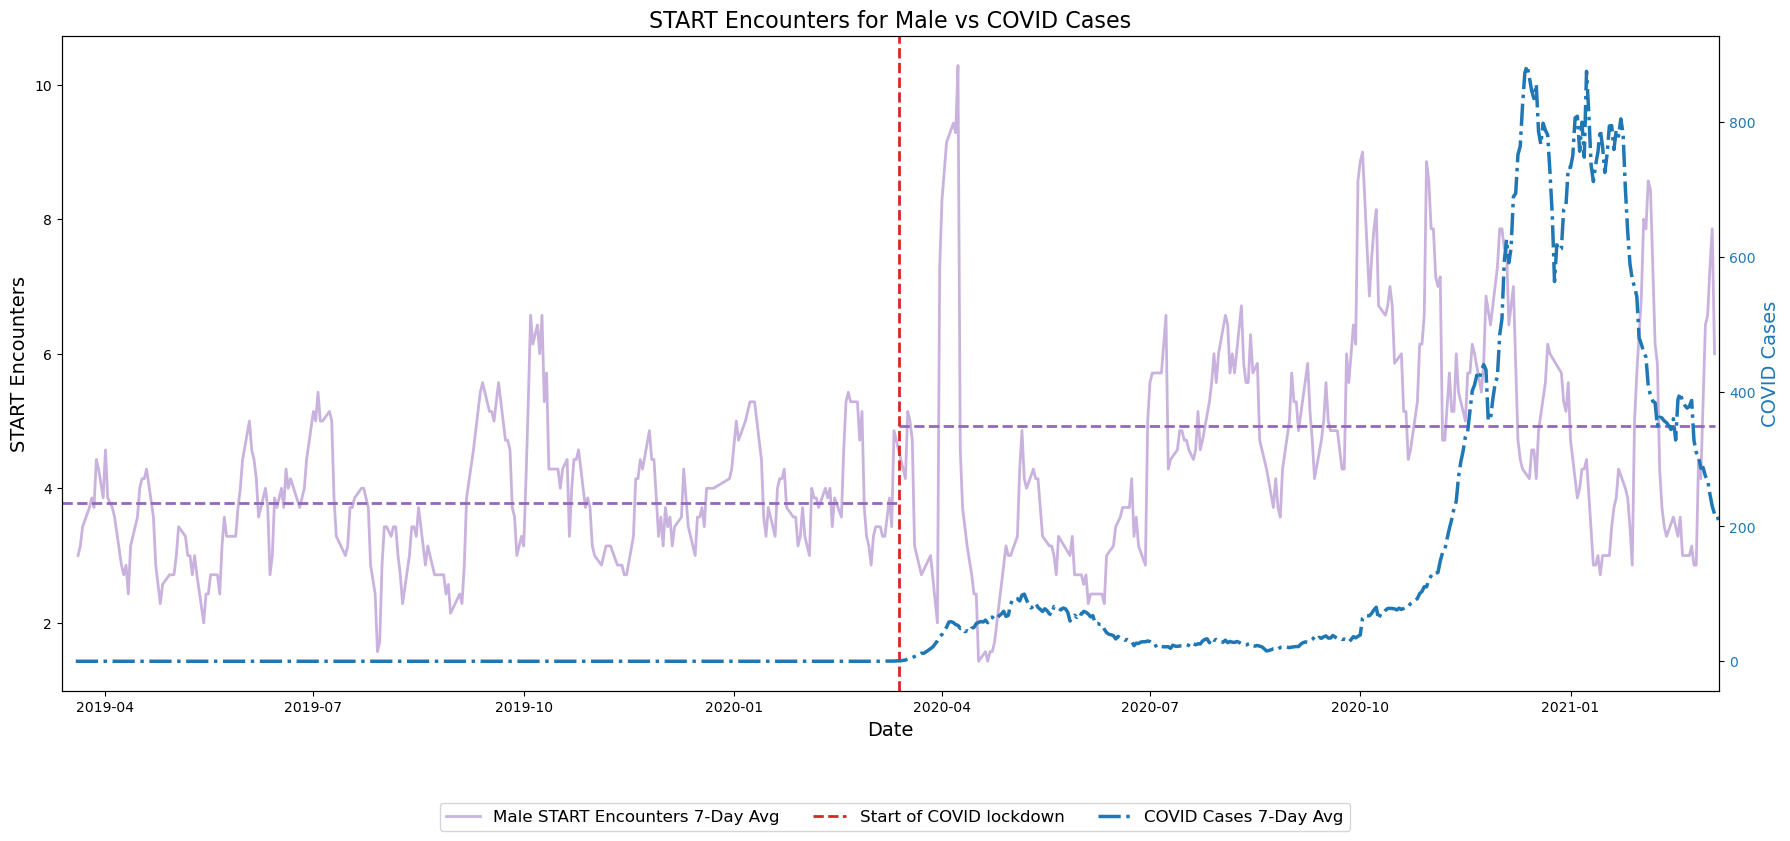

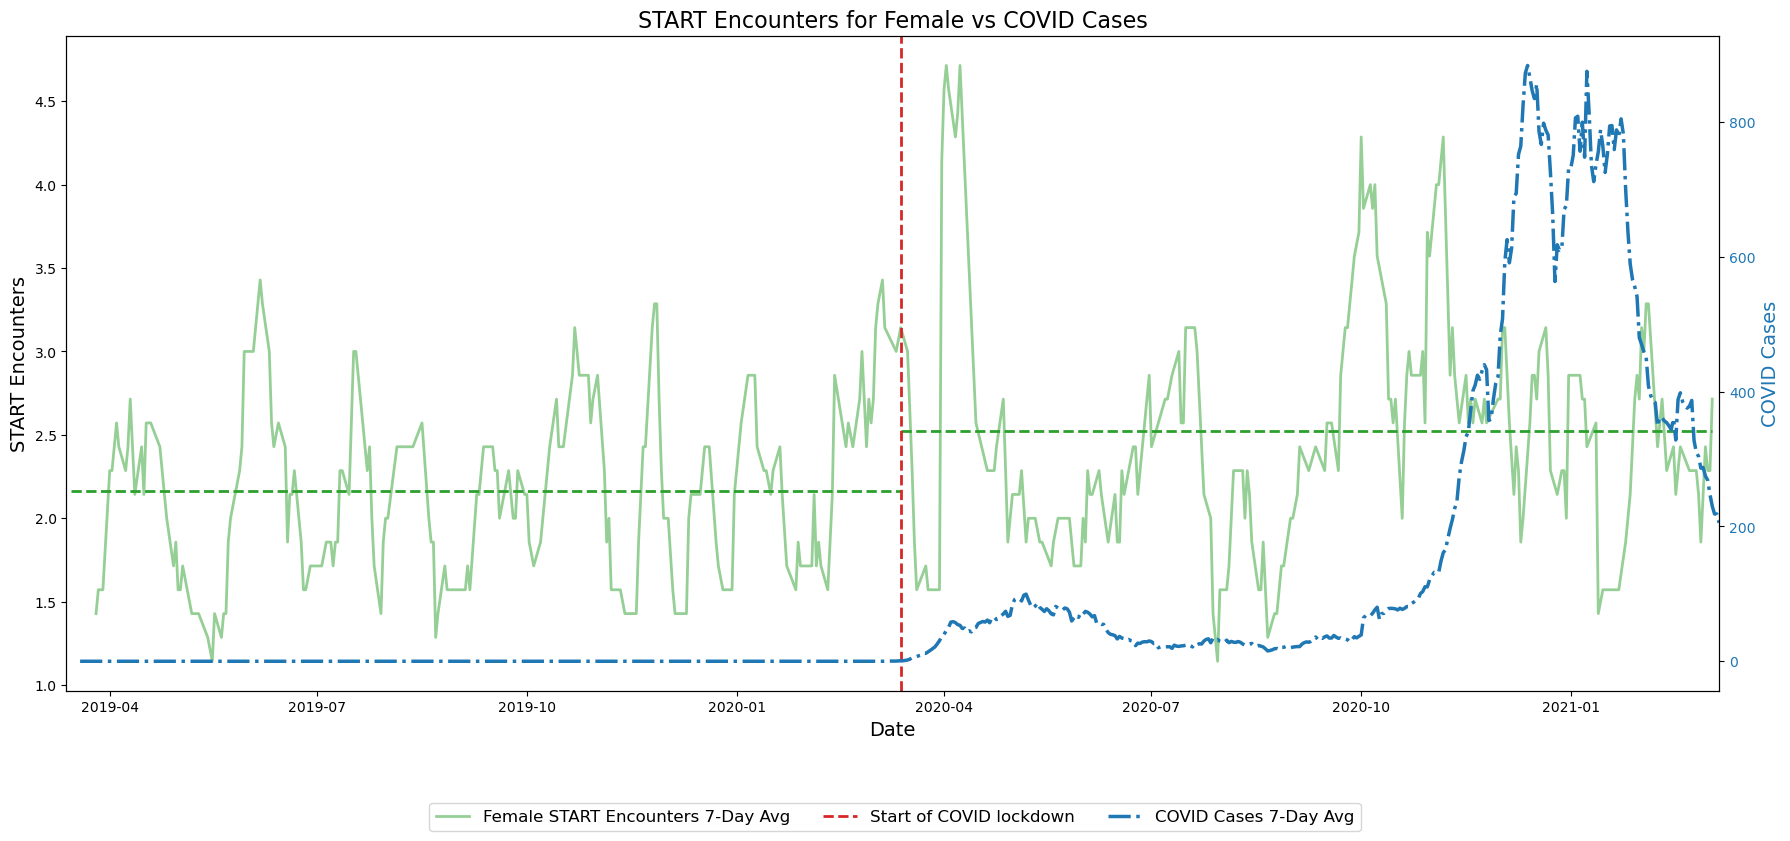

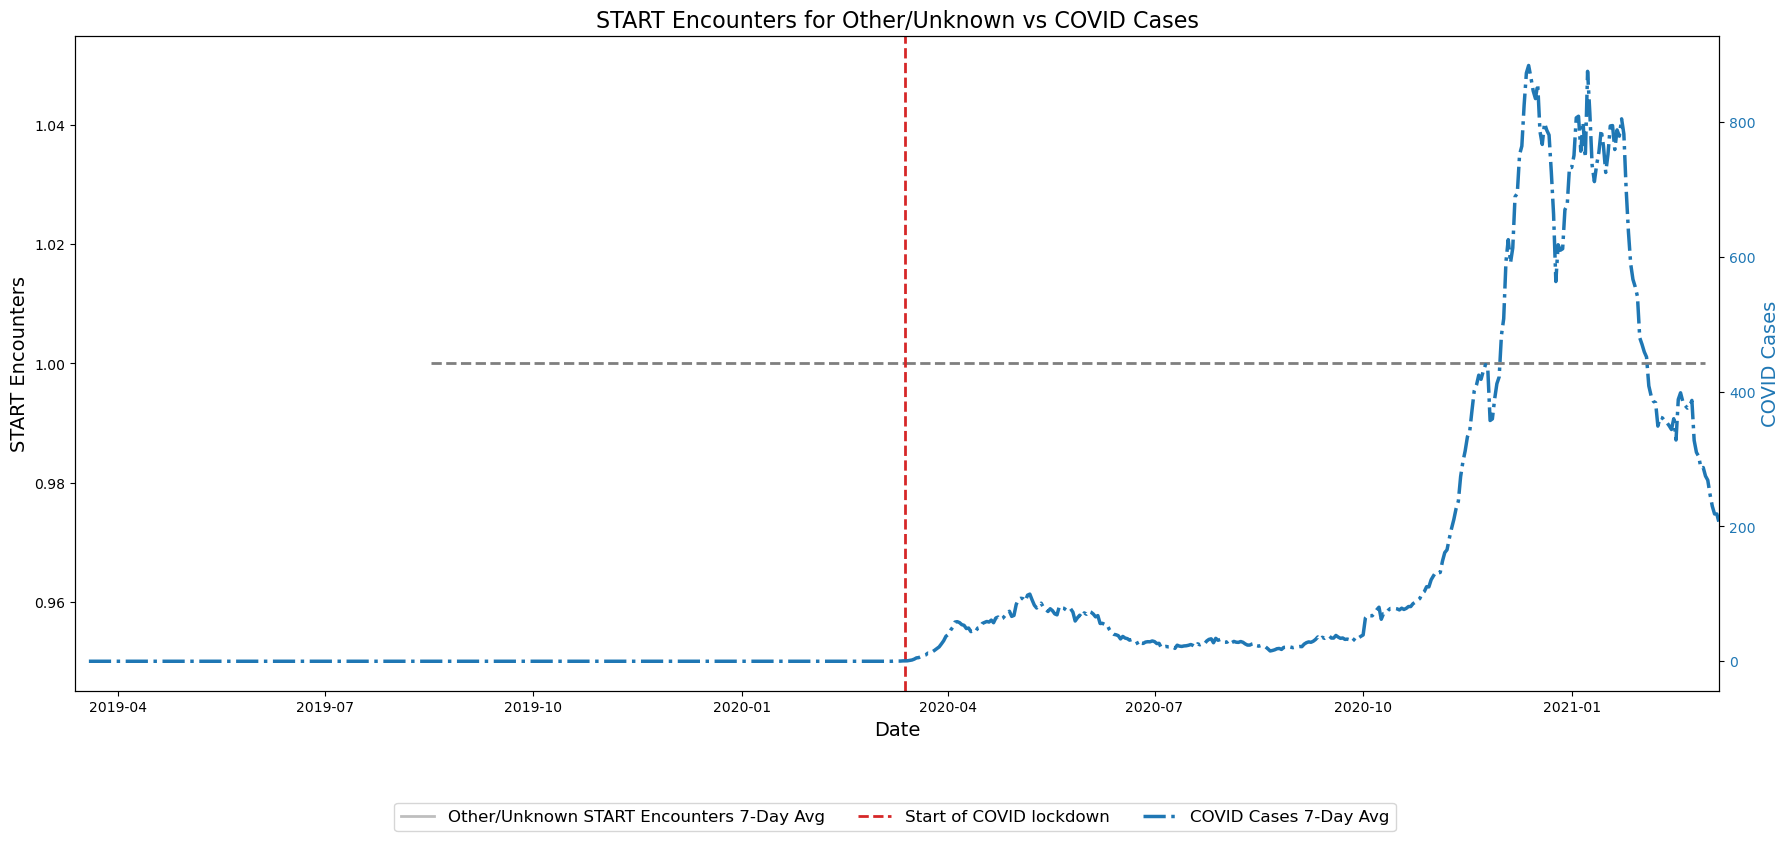

In [29]:
# Step 1: Extract and aggregate START encounters by date
sirs_demo['Status Date'] = pd.to_datetime(sirs_demo['Status Date'])
start_encounters = sirs_demo.groupby(sirs_demo['Status Date'].dt.date).size().reset_index(name='START Encounters')

# Step 2: Aggregate daily COVID cases
covid_cases_df['Date'] = pd.to_datetime(covid_cases_df['Date'])
covid_cases_aggregated = covid_cases_df.groupby(covid_cases_df['Date'].dt.date)['New cases'].sum().reset_index()

# Step 3: Extend COVID data into past (COVID cases are roughly 0 before March 2020) so we can look at pre-COVID vs post-COVID encounters
start_date = datetime.date(2019, 3, 13)
end_date = covid_cases_aggregated['Date'].max()

# Create a date range
date_range = pd.date_range(start_date, end_date).date

# Initialize empty df with the date range
extended_data = pd.DataFrame(date_range, columns=['Date'])

# Initialize empty df with the date range
extended_data = pd.DataFrame(date_range, columns=['Date'])

# Merge with the existing data to fill in the data points
extended_data = pd.merge(extended_data, covid_cases_aggregated, on='Date', how='left')

# Fill missing values for COVID cases with 0
extended_data['New cases'] = extended_data['New cases'].fillna(0)

# Extract and aggregate START encounters by gender
start_encounters_by_gender = sirs_demo.groupby([sirs_demo['Status Date'].dt.date, 'gender_clean']).size().reset_index(name='START Encounters')

# Genders and colors
genders = sirs_demo['gender_clean'].unique()
gender_colors = {
    'Male': 'tab:purple',
    'Female': 'tab:green',
    'Other/Unknown': 'tab:grey',
}

# March 13, 2020
march_13 = datetime.date(2020, 3, 13)

# Iterate through each gender and plot the data
for gender in genders:
    gender_data = start_encounters_by_gender[start_encounters_by_gender['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Plot START Encounters for the gender
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)
    
    # Plot COVID cases on secondary axis with alpha set to 0.5
    ax2 = ax1.twinx()
    ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
             label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
    ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Add vertical line on March 13
    ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)
    
    # Set labels and title
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('START Encounters', fontsize=14)
    ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
    plt.title(f'START Encounters for {gender} vs COVID Cases', fontsize=16)
    
    # Move legend outside of the plot
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
    
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

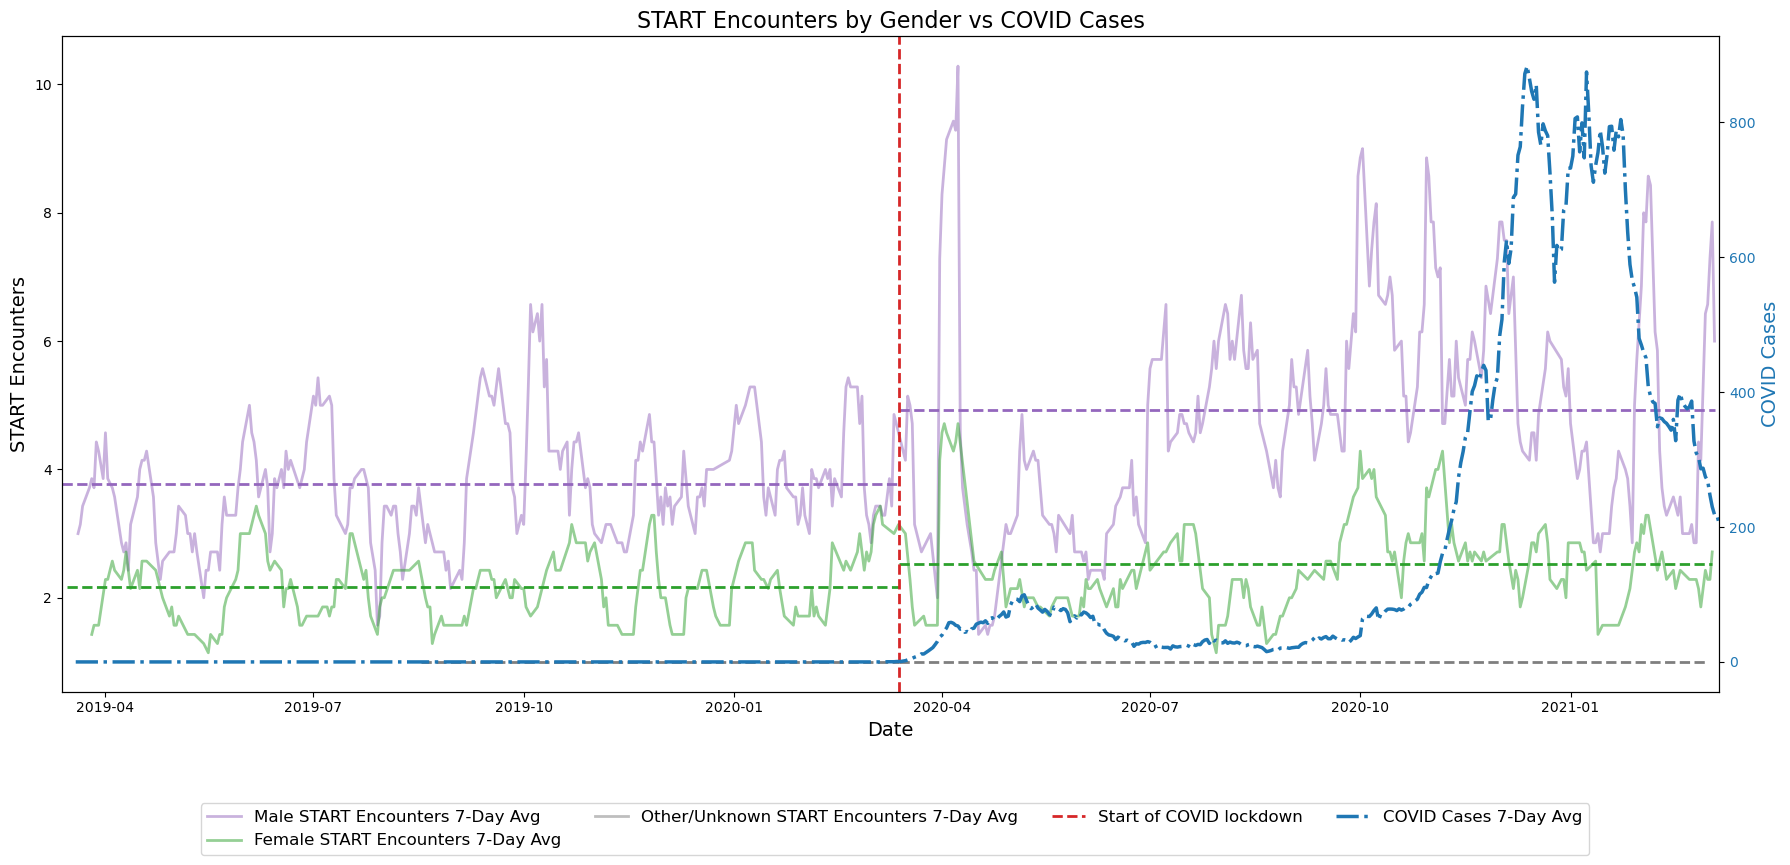

In [30]:
# Step 1: Extract and aggregate START encounters by date and gender
sirs_demo['Status Date'] = pd.to_datetime(sirs_demo['Status Date'])
start_encounters_by_gender = sirs_demo.groupby([sirs_demo['Status Date'].dt.date, 'gender_clean']).size().reset_index(name='START Encounters')

# Step 2: Define the races and colors for the plot
genders = sirs_demo['gender_clean'].unique()
gender_colors = {
    'Male': 'tab:purple',
    'Female': 'tab:green',
    'Other/Unknown': 'tab:grey',
}

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Iterate through each race and plot the data
for gender in genders:
    gender_data = start_encounters_by_gender[start_encounters_by_gender['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')
    
    # Plot START Encounters for the race
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)

# Plot COVID cases on secondary axis with alpha set to 0.5
ax2 = ax1.twinx()
ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
         label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)

# Set labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('START Encounters', fontsize=14)
ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
plt.title('START Encounters by Gender vs COVID Cases', fontsize=16)

# Move legend outside of the plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Gender and Reason for Contact

In [31]:
# Merging data frames
crisis_merge = pd.merge(sirs_crisis, sirs_demo, how = 'left', left_on = 'Individual ID', right_on = 'Local ID')

0        Female
1        Female
2        Female
3          Male
4          Male
          ...  
18163      Male
18164      Male
18165       NaN
18166    Female
18167      Male
Name: gender_clean, Length: 18168, dtype: object

In [42]:
# Cleaning data frame
crisis_col = ['Status Date',
             'Reason for Contact', 'Type of Emergency Response', 'If Police Responded',
             'gender_clean']
crisis_select = crisis_merge[crisis_col]

crisis_select

,Status Date,Reason for Contact,Type of Emergency Response,If Police Responded,gender_clean
0,2019-07-18,"At risk of losing placement, Other, Self-injur...",Phone consultation only,NaN,Female
1,2019-07-18,"Mental health symptoms, Self-injurious",In-person: Emergency room,NaN,Female
2,2019-07-18,"Mental health symptoms, Suicidal ideation/beha...",Other: phone and email,NaN,Female
3,2021-08-27,"Diagnosis and treatment plan assistance, Other...",Phone consultation only,NaN,Male
4,2021-08-27,"Aggression (physical, verbal, property destruc...",Phone consultation only,NaN,Male
...,...,...,...,...,...
18163,2021-07-14,"Aggression (physical, verbal, property destruc...",Other: In-person School,NaN,Male
18164,2020-10-07,"Family needs assistance, Mental health symptoms",Telehealth response,Assist on Site,Male
18165,NaT,Mental health symptoms,Phone consultation only,NaN,NaN
18166,2018-01-03,"At risk of losing placement, Decrease in abili...",In-person: Emergency room,Transport to ED,Female


In [45]:
# Filter by date range (April 2019 to 2021)
start_date = pd.Timestamp(datetime.date(2019, 3, 13))
filtered_crisis = crisis_select[crisis_select['Status Date'] > start_date]

filtered_crisis

,Status Date,Reason for Contact,Type of Emergency Response,If Police Responded,gender_clean
0,2019-07-18,"At risk of losing placement, Other, Self-injur...",Phone consultation only,NaN,Female
1,2019-07-18,"Mental health symptoms, Self-injurious",In-person: Emergency room,NaN,Female
2,2019-07-18,"Mental health symptoms, Suicidal ideation/beha...",Other: phone and email,NaN,Female
3,2021-08-27,"Diagnosis and treatment plan assistance, Other...",Phone consultation only,NaN,Male
4,2021-08-27,"Aggression (physical, verbal, property destruc...",Phone consultation only,NaN,Male
...,...,...,...,...,...
18158,2021-06-04,"At risk of losing placement, Other: At risk of...",Telehealth response,NaN,Female
18159,2021-06-04,"Other: running away, Self-injurious, Suicidal ...",Telehealth response,NaN,Female
18163,2021-07-14,"Aggression (physical, verbal, property destruc...",Other: In-person School,NaN,Male
18164,2020-10-07,"Family needs assistance, Mental health symptoms",Telehealth response,Assist on Site,Male


In [46]:
# Examining top reasons for contact 
filtered_crisis['Reason for Contact'].value_counts()

Reason for Contact
Aggression (physical, verbal, property destruction, threats)                                                                                                                                                                                                    2253
Mental health symptoms                                                                                                                                                                                                                                          1275
Aggression (physical, verbal, property destruction, threats), Family needs assistance                                                                                                                                                                            836
Aggression (physical, verbal, property destruction, threats), Mental health symptoms                                                                                                                  

In [48]:
# Recategorizing reasons for contact (BASIC)
filtered_crisis['is_suicidal'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Suicidal', case = False, na = False), True, False)
filtered_crisis['is_aggression'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Aggression', case = False, na = False), True, False)
filtered_crisis['is_mh_symp'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Mental health symptoms', 
                                                                                        case = False, na = False), True, False)
filtered_crisis['family_need'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Family', case = False, na = False), True, False)
filtered_crisis

C:\Users\arilo\AppData\Local\Temp\ipykernel_19172\1691470682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crisis['is_suicidal'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Suicidal', case = False, na = False), True, False)
C:\Users\arilo\AppData\Local\Temp\ipykernel_19172\1691470682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crisis['is_aggression'] = np.where(filtered_crisis['Reason for Contact'].str.contains('Aggression', case = False, na = False), True,

,Status Date,Reason for Contact,Type of Emergency Response,If Police Responded,gender_clean,is_suicidal,is_aggression,is_mh_symp,family_need
0,2019-07-18,"At risk of losing placement, Other, Self-injur...",Phone consultation only,NaN,Female,False,False,False,False
1,2019-07-18,"Mental health symptoms, Self-injurious",In-person: Emergency room,NaN,Female,False,False,True,False
2,2019-07-18,"Mental health symptoms, Suicidal ideation/beha...",Other: phone and email,NaN,Female,True,False,True,False
3,2021-08-27,"Diagnosis and treatment plan assistance, Other...",Phone consultation only,NaN,Male,False,False,False,False
4,2021-08-27,"Aggression (physical, verbal, property destruc...",Phone consultation only,NaN,Male,False,True,True,True
...,...,...,...,...,...,...,...,...,...
18158,2021-06-04,"At risk of losing placement, Other: At risk of...",Telehealth response,NaN,Female,False,False,False,False
18159,2021-06-04,"Other: running away, Self-injurious, Suicidal ...",Telehealth response,NaN,Female,True,False,False,False
18163,2021-07-14,"Aggression (physical, verbal, property destruc...",Other: In-person School,NaN,Male,False,True,True,False
18164,2020-10-07,"Family needs assistance, Mental health symptoms",Telehealth response,Assist on Site,Male,False,False,True,True


In [50]:
# Suicidal Proportions
suicidal_crisis = filtered_crisis.groupby('gender_clean')['is_suicidal'].sum()
suicidal_total = suicidal_crisis.sum()
suicidal_prop = suicidal_crisis / suicidal_total

suicidal_prop

gender_clean
Female    0.616719
Male      0.383281
Name: is_suicidal, dtype: float64

In [51]:
# Aggression Proportions
aggression_crisis = filtered_crisis.groupby('gender_clean')['is_aggression'].sum()
aggression_total = aggression_crisis.sum()
aggression_prop = aggression_crisis / aggression_total

aggression_prop

gender_clean
Female    0.363962
Male      0.636038
Name: is_aggression, dtype: float64

In [52]:
# Mental Health Symptoms Proportions
mh_crisis = filtered_crisis.groupby('gender_clean')['is_mh_symp'].sum()
mh_total = mh_crisis.sum()
mh_prop = mh_crisis / mh_total

mh_prop

gender_clean
Female    0.509651
Male      0.490349
Name: is_mh_symp, dtype: float64

In [53]:
family_crisis = filtered_crisis.groupby('gender_clean')['family_need'].sum()
family_total = family_crisis.sum()
family_prop = family_crisis / family_total

family_prop

gender_clean
Female    0.300583
Male      0.699417
Name: family_need, dtype: float64

In [56]:
gender_crisis_df = pd.DataFrame({
    'suicidal_ideation': suicidal_prop,
    'aggression': aggression_prop,
    'mental_health': mh_prop,
    'family_need': family_prop,
})

gender_crisis_df

,suicidal_ideation,aggression,mental_health,family_need
gender_clean,,,,
Female,0.616719,0.363962,0.509651,0.300583
Male,0.383281,0.636038,0.490349,0.699417


# START encounters involving aggression by gender during COVID

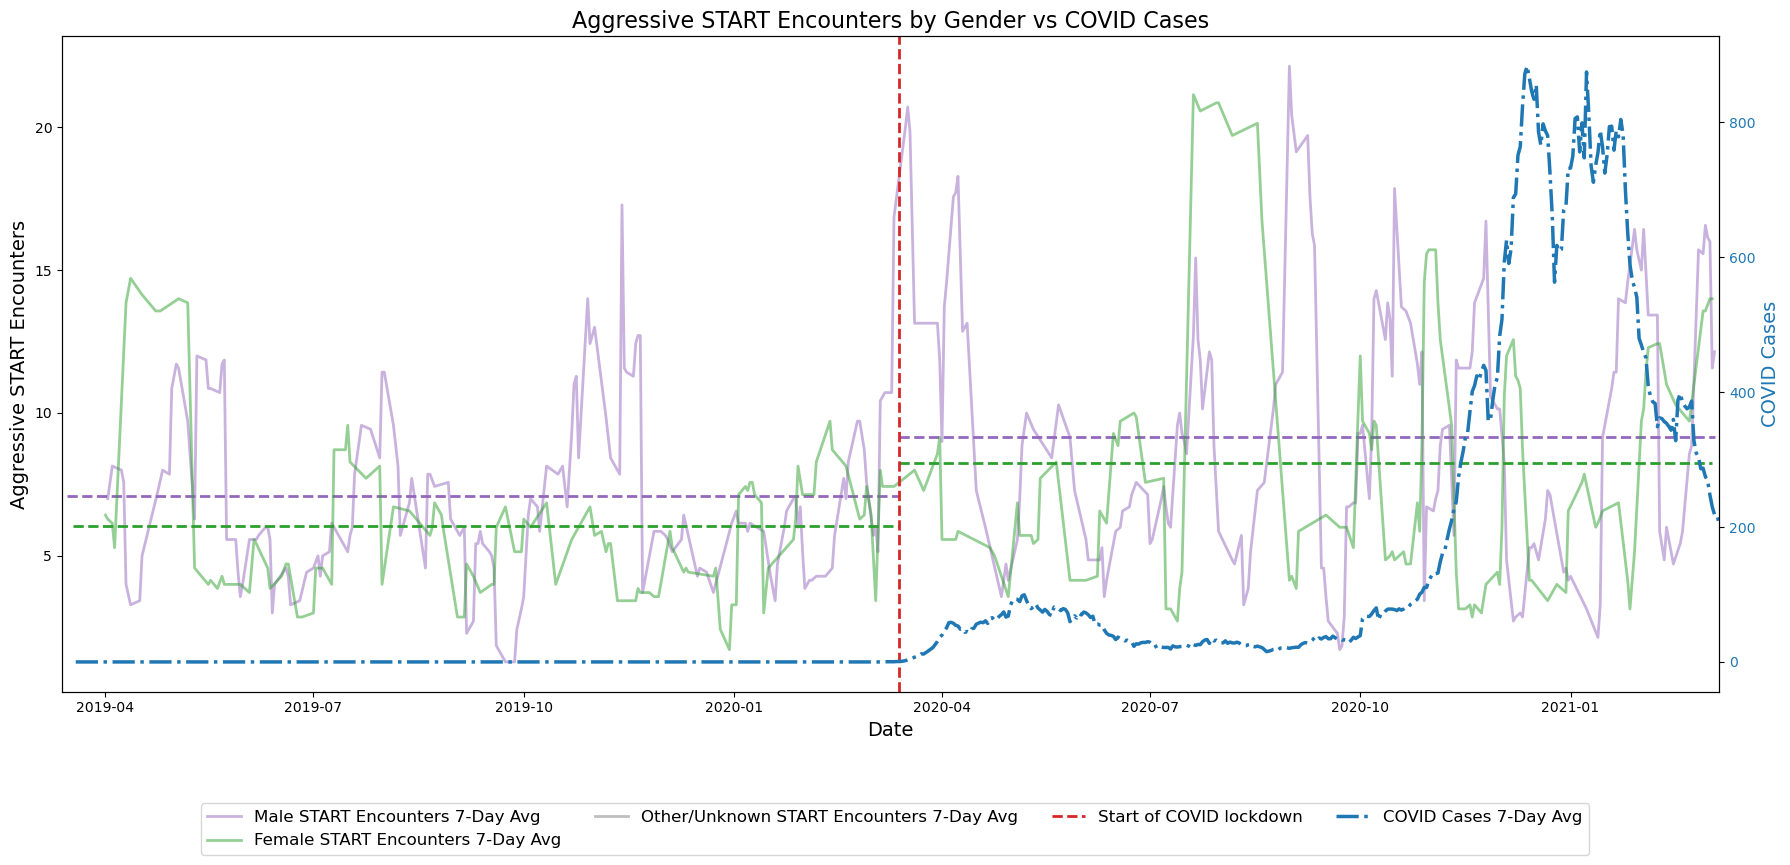

In [63]:
# Step 1: Extract and aggregate START encounters by date and gender
start_encounters_by_gender = filtered_crisis.groupby([filtered_crisis['Status Date'].dt.date, 'gender_clean', 'is_suicidal', 'is_aggression', 'is_mh_symp', 
                                                    'family_need']).size().reset_index(name='START Encounters')

by_aggression = start_encounters_by_gender[start_encounters_by_gender['is_aggression'] == True]
by_aggression


# Step 2: Define the gender and colors for the plot
genders = sirs_demo['gender_clean'].unique()
gender_colors = {
    'Male': 'tab:purple',
    'Female': 'tab:green',
    'Other/Unknown': 'tab:grey',
}

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Iterate through each race and plot the data
for gender in genders:
    gender_data = by_aggression[by_aggression['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')
    
    # Plot START Encounters for the race
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)

# Plot COVID cases on secondary axis with alpha set to 0.5
ax2 = ax1.twinx()
ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
         label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)

# Set labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Aggressive START Encounters', fontsize=14)
ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
plt.title('Aggressive START Encounters by Gender vs COVID Cases', fontsize=16)

# Move legend outside of the plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

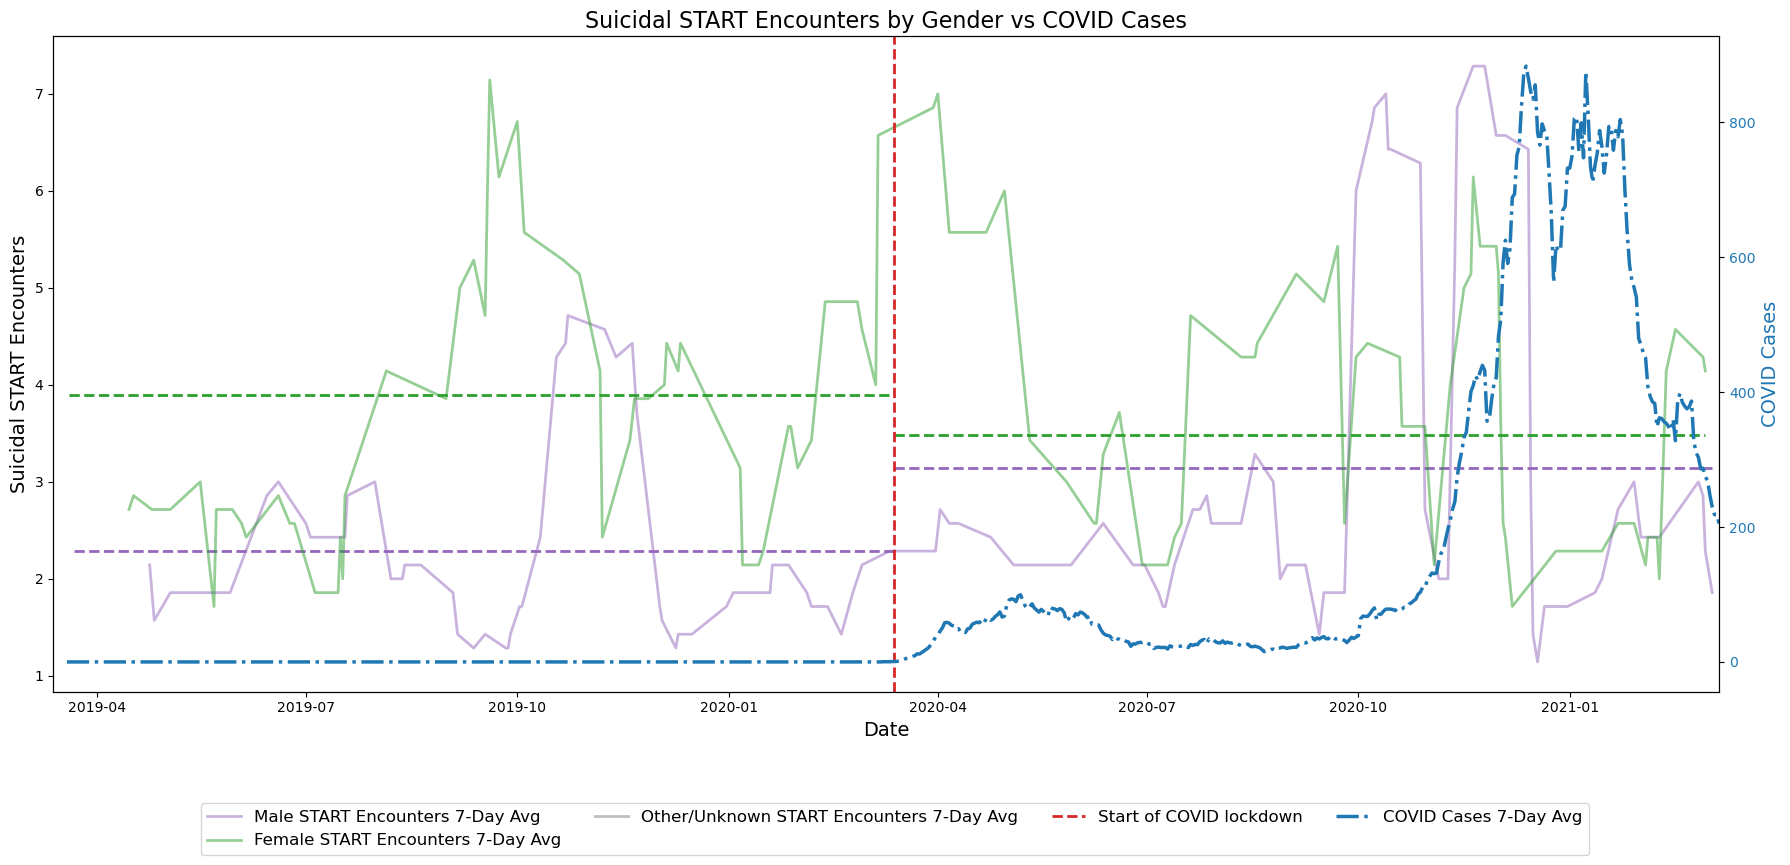

In [64]:
by_suicidal = start_encounters_by_gender[start_encounters_by_gender['is_suicidal'] == True]
by_suicidal

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Iterate through each race and plot the data
for gender in genders:
    gender_data = by_suicidal[by_suicidal['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')
    
    # Plot START Encounters for the race
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)

# Plot COVID cases on secondary axis with alpha set to 0.5
ax2 = ax1.twinx()
ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
         label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)

# Set labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Suicidal START Encounters', fontsize=14)
ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
plt.title('Suicidal START Encounters by Gender vs COVID Cases', fontsize=16)

# Move legend outside of the plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

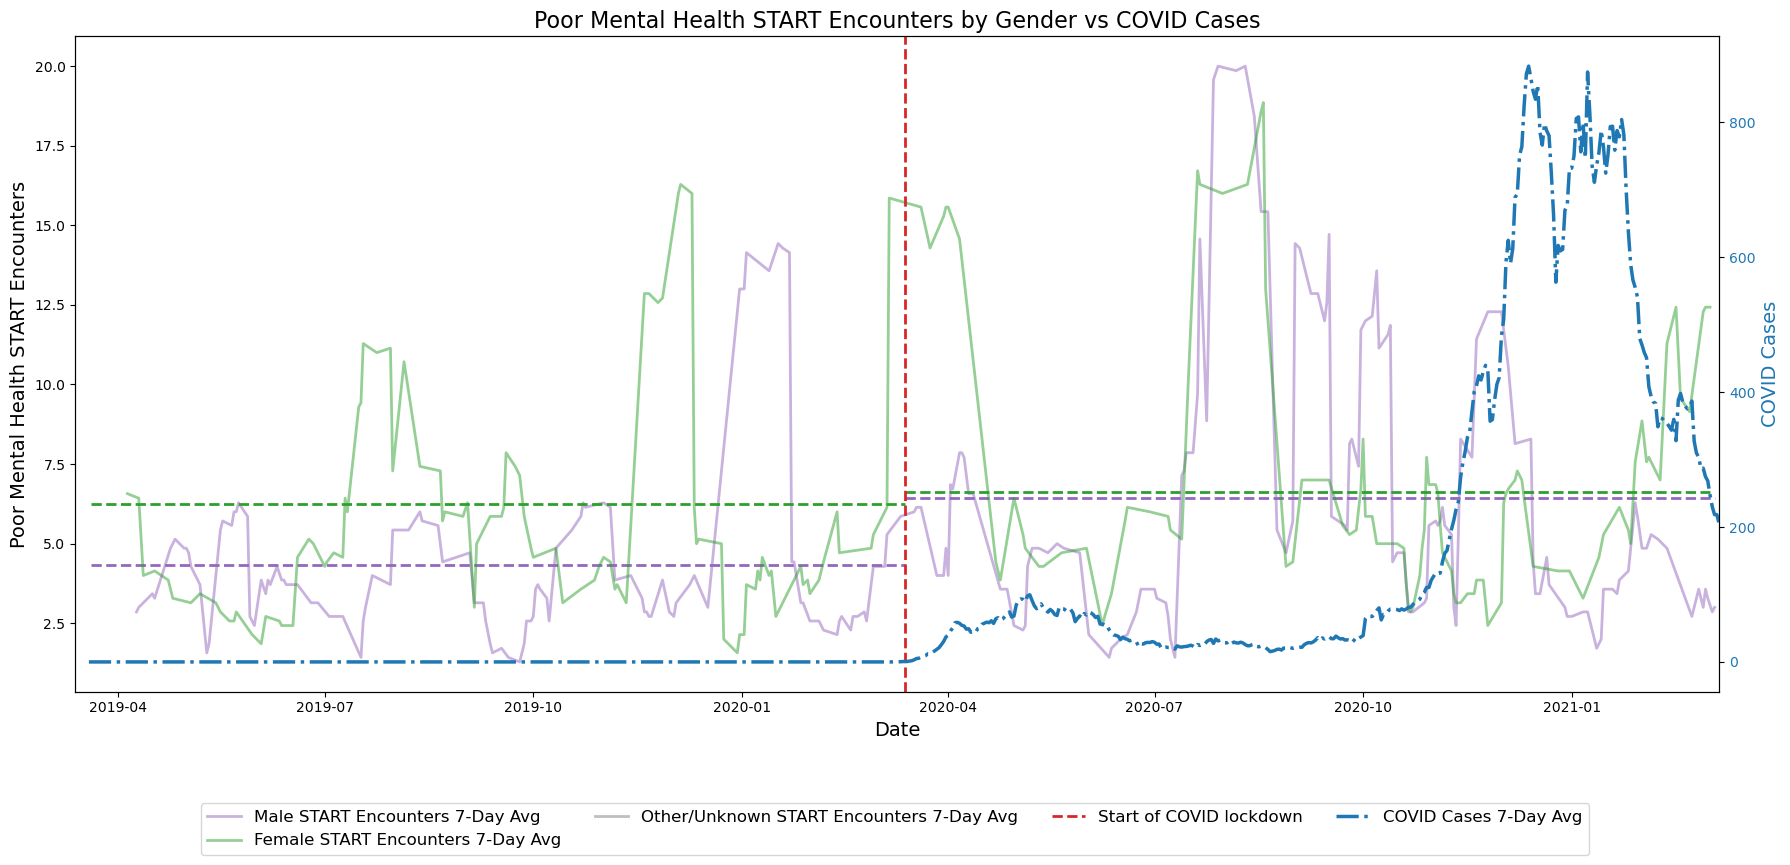

In [65]:
by_mh = start_encounters_by_gender[start_encounters_by_gender['is_mh_symp'] == True]
by_mh

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Iterate through each race and plot the data
for gender in genders:
    gender_data = by_mh[by_mh['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')
    
    # Plot START Encounters for the race
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)

# Plot COVID cases on secondary axis with alpha set to 0.5
ax2 = ax1.twinx()
ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
         label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)

# Set labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Poor Mental Health START Encounters', fontsize=14)
ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
plt.title('Poor Mental Health START Encounters by Gender vs COVID Cases', fontsize=16)

# Move legend outside of the plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

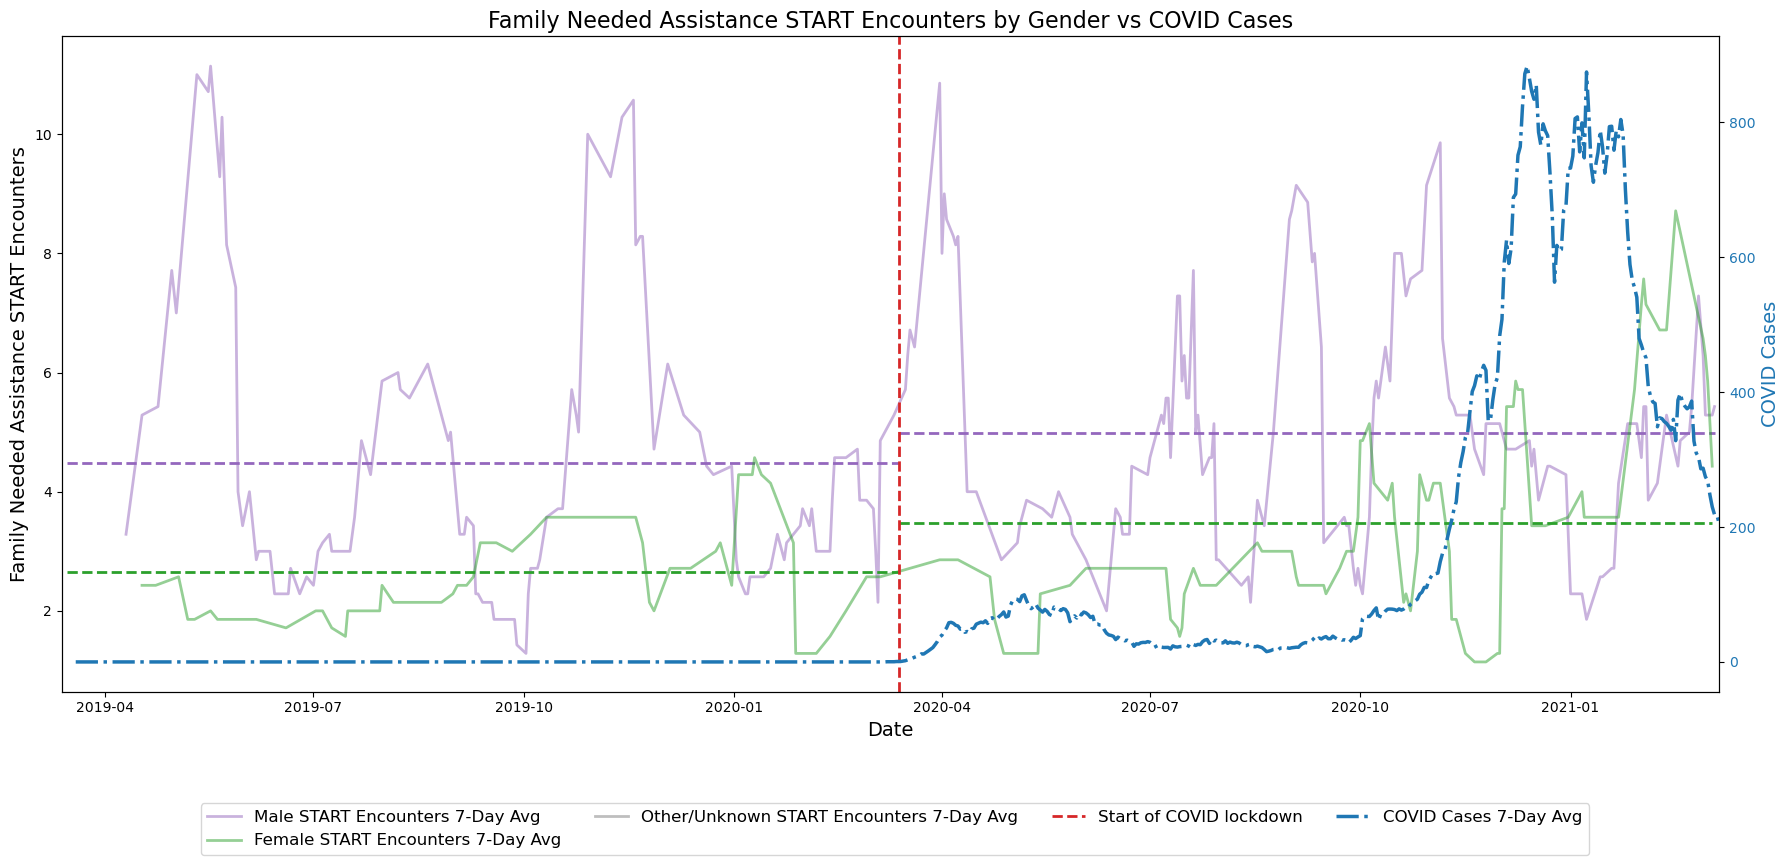

In [66]:
by_family = start_encounters_by_gender[start_encounters_by_gender['family_need'] == True]
by_family

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Iterate through each race and plot the data
for gender in genders:
    gender_data = by_family[by_family['gender_clean'] == gender]
    gender_data = gender_data.groupby('Status Date')['START Encounters'].sum().reset_index()
    
    merged_data = pd.merge(gender_data, extended_data, left_on='Status Date', right_on='Date', how='inner')
    merged_data = merged_data[['Date', 'START Encounters', 'New cases']]
    
    # Calculate rolling averages
    merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
    merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()
    
    # Calculate average encounters before and after COVID
    pre_covid_avg = merged_data[merged_data['Date'] < march_13]['START Encounters'].mean()
    post_covid_avg = merged_data[merged_data['Date'] >= march_13]['START Encounters'].mean()
    
    color = gender_colors.get(gender, 'gray')
    
    # Plot START Encounters for the race
    ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], 
             label=f'{gender} START Encounters 7-Day Avg', color=color, linewidth=2, alpha=0.5)
    
    # Add horizontal lines for average encounters before and after COVID only on their side of the vertical line
    ax1.hlines(pre_covid_avg, merged_data['Date'].min(), march_13, color=color, linestyle='--', linewidth=2)
    ax1.hlines(post_covid_avg, march_13, merged_data['Date'].max(), color=color, linestyle='--', linewidth=2)

# Plot COVID cases on secondary axis with alpha set to 0.5
ax2 = ax1.twinx()
ax2.plot(extended_data['Date'], extended_data['New cases'].rolling(window=7).mean(), 
         label='COVID Cases 7-Day Avg', color='tab:blue', linewidth=2.5, linestyle='-.')
ax2.set_ylabel('COVID Cases', color='tab:blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown', linewidth=2)

# Set labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Family Needed Assistance START Encounters', fontsize=14)
ax1.set_xlim([extended_data['Date'].min(), extended_data['Date'].max()])
plt.title('Family Needed Assistance START Encounters by Gender vs COVID Cases', fontsize=16)

# Move legend outside of the plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()